# **Fine-tuning with LED**

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


● Upload the csv file into a folder “Code Cycle” in your google drive

● Open a colab notebook and change the runtime type to T4 GPU.

● Open files section on the left and mount your drive (give permission)


In [2]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [3]:
from datasets import load_metric
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Code Cycle/articlesSet.csv")
df.head()

,title,summary,content
0,Mental Note Vol. 24,If I cannot find peace and contentment within ...,Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1,Your Brain On Coronavirus,"Many individuals experience pain, fatigue and ...",Your Brain On Coronavirus\n\nA guide to the cu...
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,Mind Your Nose\n\nHow smell training can chang...
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,Passionate about the synergy between science a...
4,Surviving a Rod Through the Head,"The iron rod went through his brain, in partic...","You’ve heard of him, haven’t you? Phineas Gage..."


In [4]:
print(df.shape)
df = df.dropna()
print(df.shape)

(831, 3)
(831, 3)


# Dealing with Outliers

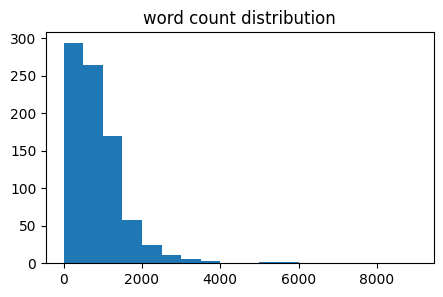

In [6]:
df['length'] = df.content.map(lambda x: len(x.split(" ")))

numofwords = df.length
from matplotlib import pyplot as plt

# Creating plot
fig = plt.figure(figsize =(5, 3))
plt.hist(numofwords.to_numpy(), bins = [0, 500, 1000, 1500,
2000, 2500, 3000, 3500, 4000, 5000, 6000, 7000, 8000, 9000])
plt.title("word count distribution")

# show plot
plt.show()

As shown in the histogram, it is clear that there
are some very few paragraphs which have upto 8000 words.

In [7]:
tempDf = df[df.length <= 800]
tempDf = tempDf[tempDf.length >= 100]
tempDf.shape

(449, 4)

we removed around 400 articles.

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Tokenizing

In [9]:
max_input_length = 1024
max_output_length = 1024
batch_size = 4

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )

    outputs = tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


Data spliting

In [10]:
import numpy as np
train, validate, test = np.split(tempDf.sample(frac=1, random_state=42), [int(.4*len (df)), int(.5*len (df))])
print(train.shape, validate.shape)
train = train [0:250]
validate = validate [25:50]
print(train.shape, validate.shape)

(332, 4) (83, 4)
(250, 4) (25, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary", "length", "__index_level_0__"],
)

val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary", "length", "__index_level_0__"],
)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [12]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

# it's time to train the model with our data.

> We’ll be using ** rouge** metric for
measuring performance.




In [13]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments

led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# set generate hyperparameters
led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 512
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# enable fp16 apex training
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2
)


Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [14]:
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [15]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 250
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 30
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will 

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.661600,2.487429,0.203200,0.354800,0.248300


The following columns in the evaluation set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25
  Batch size = 4
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for m

KeyboardInterrupt: 

In [16]:
sample = tempDf.sample(frac=0.005, random_state=12)
sample.shape
sample = sample [['content', 'summary']]
sample['content']

,content
157,It’d be easy for me to blame being out of shap...
78,Every time I think people can’t amaze me furth...


# Finally we got it ! Inference!

In [17]:
from datasets import Dataset
pubmed_test = Dataset.from_pandas(sample)
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

# load tokenizer
tokenizer = LEDTokenizer.from_pretrained("/content/drive/MyDrive/checkpoint-10")
model = LEDForConditionalGeneration.from_pretrained("/content/drive/MyDrive/checkpoint-10").to("cuda").half()

def generate_answer(batch):
  inputs_dict = tokenizer(batch["summary"], padding="max_length", max_length=1024, return_tensors="pt", truncation=True)
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["predicted_content"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

result = pubmed_test.map(generate_answer, batched=True, batch_size=2)

Didn't find file /content/drive/MyDrive/checkpoint-10/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/checkpoint-10/vocab.json
loading file /content/drive/MyDrive/checkpoint-10/merges.txt
loading file None
loading file /content/drive/MyDrive/checkpoint-10/special_tokens_map.json
loading file /content/drive/MyDrive/checkpoint-10/tokenizer_config.json
loading configuration file /content/drive/MyDrive/checkpoint-10/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [18]:
result['content'][1]

'Every time I think people can’t amaze me further with their stupidity, I’m sadly mistaken. Yes, stupidity. Or would you rather I say dangerous behavior? Either works.\n\nAs of today, in the United States alone, there have been 13.7m cases of the novel coronavirus, with almost 270k deaths.\n\nWhat in those numbers gives you the idea that travel is a good idea? Now, it would be one thing if people were vacationing to parts unknown, not surrounding themselves with people. But that’s really not the case. People are still going to Disney. The park recently announced they’re open for business again, minus the water parks.\n\nJust be sure if you’re over the age of 2, you wear a mask at all times.\n\nWearing a mask is important for sure. But you can’t tell me a crowd the size of the ones that frequent Disney isn’t a recipe for disaster. It’s not only dangerous, it’s destructive. No amount of memory making is worth the potential for death, or at the least, severe illness.\n\nI blame the compan

In [19]:
result['predicted_content'][1]

"But I also blame the people of the United States who can’t put their plans on hold for a little longer in order to remain safe, and for the health and well-being of others. Consistently masking up, only going out when absolutely necessary, and avoiding crowds goes a long way towards ending this pandemic. Every time I think people can‘t amaze me further with their stupidity, I’m sadly mistaken. As of today, there have been 13.7m cases of the novel coronavirus, with almost 270k deaths. We’ve been stuck at home since March, invading one another’s space, constantly under each other. We even avoided a small Thanksgiving get-together to ensure we remained virus free. But for all that is holy, stay home this holiday season and plan the vacations for when it’ll be safer. I know it sounds crazy, but it‘s true. We have a lot of people who are sick, and we’re not the only ones who are. And we have a great deal of friends and family that are sick. And that’d be great if we could just stay home an